In [2]:
#Purpose: Extract EIS data from Scribner software for HFR data
#Author: Shan Kutagulla
#Organization: Univ. of Texas at Austin

In [3]:
#!pip3 install pandas
#!pip3 install fsspec
#!pip3 install smbprotocol
#!pip3 install pandas
#!pip3 install matplotlib
#!pip3 install openpyxl

In [4]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import openpyxl
import numpy as np
import scipy.signal

In [54]:
import warnings
warnings.filterwarnings("ignore")
TITLE="NC700_Baseline_02172022_EIS"
AREA=25; #in cm^2

In [55]:
#Administrative stuff, read in data and flip imaginary axis
filename="//Users/shanmukhkutagulla/My Drive/Fuel Cell Docs/Bare Nafion Control Baselines/Nafion bare 02172022/NC700_Baseline_02172022_EIS.fcd"
data=pd.read_csv(filename, skiprows=43, delimiter="\t", usecols=["Z_Real (Ohm)","Z_Imag (Ohm)","Z_Freq (Hz)"])
data=data.drop(0,axis=0).reindex()
data["Z_Imag_Neg (Ohm)"]=data["Z_Imag (Ohm)"]*-1

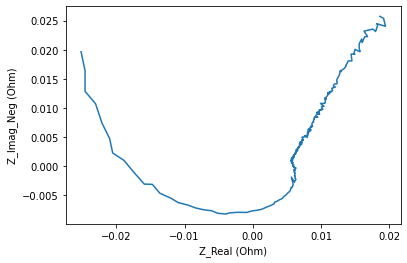

In [56]:
plt.plot(data["Z_Real (Ohm)"],data["Z_Imag_Neg (Ohm)"])
plt.xlabel("Z_Real (Ohm)");
plt.ylabel("Z_Imag_Neg (Ohm)");

In [57]:
#fit graph to polynomial and determine leftmost minima
def determine_eis_hfr(x_val,y_val,degree_N, area_active): #Use leftmost minima to determin HFR
    quadfit=np.polyfit(x_val,y_val,deg=degree_N) #fit curve to smooth
    y_fit=0
    for i in range(0,degree_N+1):
            y_fit=y_fit+quadfit[i]*x_val**((degree_N-i)) #develop points for fit
    plt.plot(data["Z_Real (Ohm)"],data["Z_Imag_Neg (Ohm)"]) #plot real
    plt.xlabel("Z_Real (Ohm)")
    plt.ylabel("Z_Imag_Neg (Ohm)")
    plt.plot(data["Z_Real (Ohm)"],y_fit) #Plot fit 
    
    index=scipy.signal.argrelmin(y_fit.values, order=3) #Use 3 points on either side to determine if minima or not
    minima_hfr=index[0][0] #obtain leftmost point
    x_hfr_val=x_val.iloc[minima_hfr]*area_active #multiply by active area of MEA
    y_hfr_val=y_val.iloc[minima_hfr]
    return x_hfr_val, y_hfr_val
    

In [58]:
def axis_cross_hfr(df, active_area): #Uses axis cross method
    df=df[df["Z_Real (Ohm)"]>0]
    df["Sign"]=np.sign(df["Z_Imag_Neg (Ohm)"])
    df=df[df["Sign"]>0]
    #print(df)
    hfr_x=df["Z_Real (Ohm)"].iloc[0]*active_area
    hfr_y=df["Z_Imag_Neg (Ohm)"].iloc[0]
    hfr_freq=df["Z_Freq (Hz)"].iloc[0]
    return hfr_x,hfr_y,hfr_freq

The HFR for this MEA is: 0.1463575 Ohms-cm^2
This HFR occurs at a frequency of: 1819.7 Hz
Standard Nafion HFR (at 80 C 100% RH 150 kPa): 0.05 Ohms-cm^2
This MEA conducts at an efficiency of: 0.3416292297969014 in comparison to Nafion at normal conditions


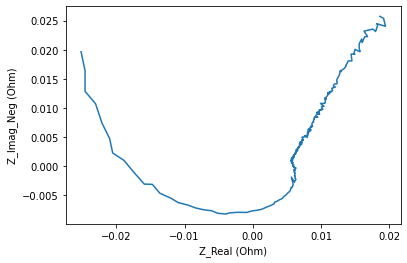

In [60]:
hfr_x_cross, hfr_y_cross, hfr_freq_cross=axis_cross_hfr(data,25);
plt.plot(data["Z_Real (Ohm)"],data["Z_Imag_Neg (Ohm)"])
plt.xlabel("Z_Real (Ohm)");
plt.ylabel("Z_Imag_Neg (Ohm)");
print("The HFR for this MEA is: "+ str(hfr_x_cross) + " Ohms-cm^2")
print("This HFR occurs at a frequency of: "+ str(hfr_freq_cross)+ " Hz")
print("Standard Nafion HFR (at 80 C 100% RH 150 kPa): 0.05 Ohms-cm^2")
print("This MEA conducts at an efficiency of: " + str(0.05/hfr_x_cross)+ " in comparison to Nafion at normal conditions")

In [53]:
export_df=pd.DataFrame()
export_df["MEA Tested"]=[TITLE]
export_df["HFR (ohm-cm^2)"]=[hfr_x_cross]
export_df["HFR Frequency (Hz)"]=[hfr_freq_cross]
string="/Users/shanmukhkutagulla/My Drive/Fuel Cell Docs/EIS Processed Files/"+TITLE+".eis"
export_df.to_csv(string,index=False)

The HFR for this MEA is: -0.0930525 Ohms-cm^2
Standard Nafion HFR: 0.05 Ohms-cm^2
This MEA conducts at an efficiency of: -0.5373310765428119 in comparison to Nafion


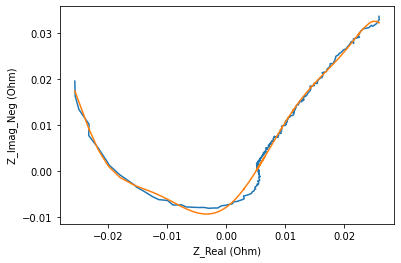

In [49]:
hfr_x, hfr_y=determine_eis_hfr(data["Z_Real (Ohm)"], data["Z_Imag_Neg (Ohm)"],degree_N=8, area_active=AREA) #Use an x^8 curve fir with an active area of 25 cm2
print("The HFR for this MEA is: "+ str(hfr_x) + " Ohms-cm^2")
print("Standard Nafion HFR: 0.05 Ohms-cm^2")
print("This MEA conducts at an efficiency of: " + str(0.05/hfr_x)+ " in comparison to Nafion")